# View the results of the QNMRF for GW150914
Need to run with an environment the `qnm_filter` module installed. Can be found in XXXXXX

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import scipy as sp
import re
import qnm_filter
import glob
import os
from natsort import natsorted
import matplotlib
mplparams = {
    'text.usetex': True,
    'axes.linewidth': 1,
    'lines.linewidth' : 1.5,
    'axes.grid': False,
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 26,
    'figure.figsize': (15, 15),
    'legend.fontsize': 26,
    'legend.handlelength' : 2,
    'legend.numpoints' : 1,
    'axes.grid' : True,
    'grid.alpha' : 0.5,
}
matplotlib.rcParams.update(mplparams)

directory = os.path.abspath("")+'/results/'
IMR = {'mass': 67.63111300244529,
       'chi': 0.6844285340439135} 

In [3]:
red = '#D60606'
blue = '#0083DE'
green = '#00BA75'
yellow = '#FFC61E'
purple = '#A433B3'
orange = '#FD882E'
color_arr = [red, blue, green, yellow, purple, orange]

In [4]:
thresh_dict = {
#     '220+200:220': 7.25,
    '220+221:220': 6.35,
    '220+210:220': 7.25,
#     '220+330:220': 5.70,
#     '220+440:220': 6.67,
}

In [5]:
def load_data(filename):
    likelihood_data = np.loadtxt(str(directory+filename))
    evidence = sp.special.logsumexp(likelihood_data)
    
    # Metadata
    f = open(directory+filename)
    header = f.readline()[2:]

    time_patt = r"time=(\d+\.\d+)"
    time_offset = float(re.search(time_patt, header).group(1))

    evidence_patt = r"evidence=(-\d+\.\d+)"
    evidence = float(re.search(evidence_patt, header).group(1))

    filter_patt = r"model_list=(.*?)\,"
    filter_str = re.search(filter_patt, header).group(1)

    credible_patt = r"credible=(-\d+\.\d+)"
    credible = float(re.search(credible_patt, header).group(1))

    chi_patt = r"chi_bounds=\((\d+\.\d+)_(\d+\.\d+)\)"
    chi_match = re.search(chi_patt, header)
    chi_lower = float(chi_match.group(1))
    chi_upper = float(chi_match.group(2))

    mass_patt = r"mass_bounds=\((\d+)_(\d+)\)"
    mass_match = re.search(mass_patt, header)
    mass_lower = float(mass_match.group(1))
    mass_upper = float(mass_match.group(2))

    massspace = np.linspace(mass_lower, mass_upper, likelihood_data.shape[1], endpoint=False)
    chispace = np.linspace(chi_lower, chi_upper, likelihood_data.shape[0], endpoint=False)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, np.diff(massspace)[0], np.diff(chispace)[0])
    
    return likelihood_data, evidence, time_offset, filter_str, credible, \
            chi_lower, chi_upper, mass_lower, mass_upper, \
            massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi

## Evidence curve

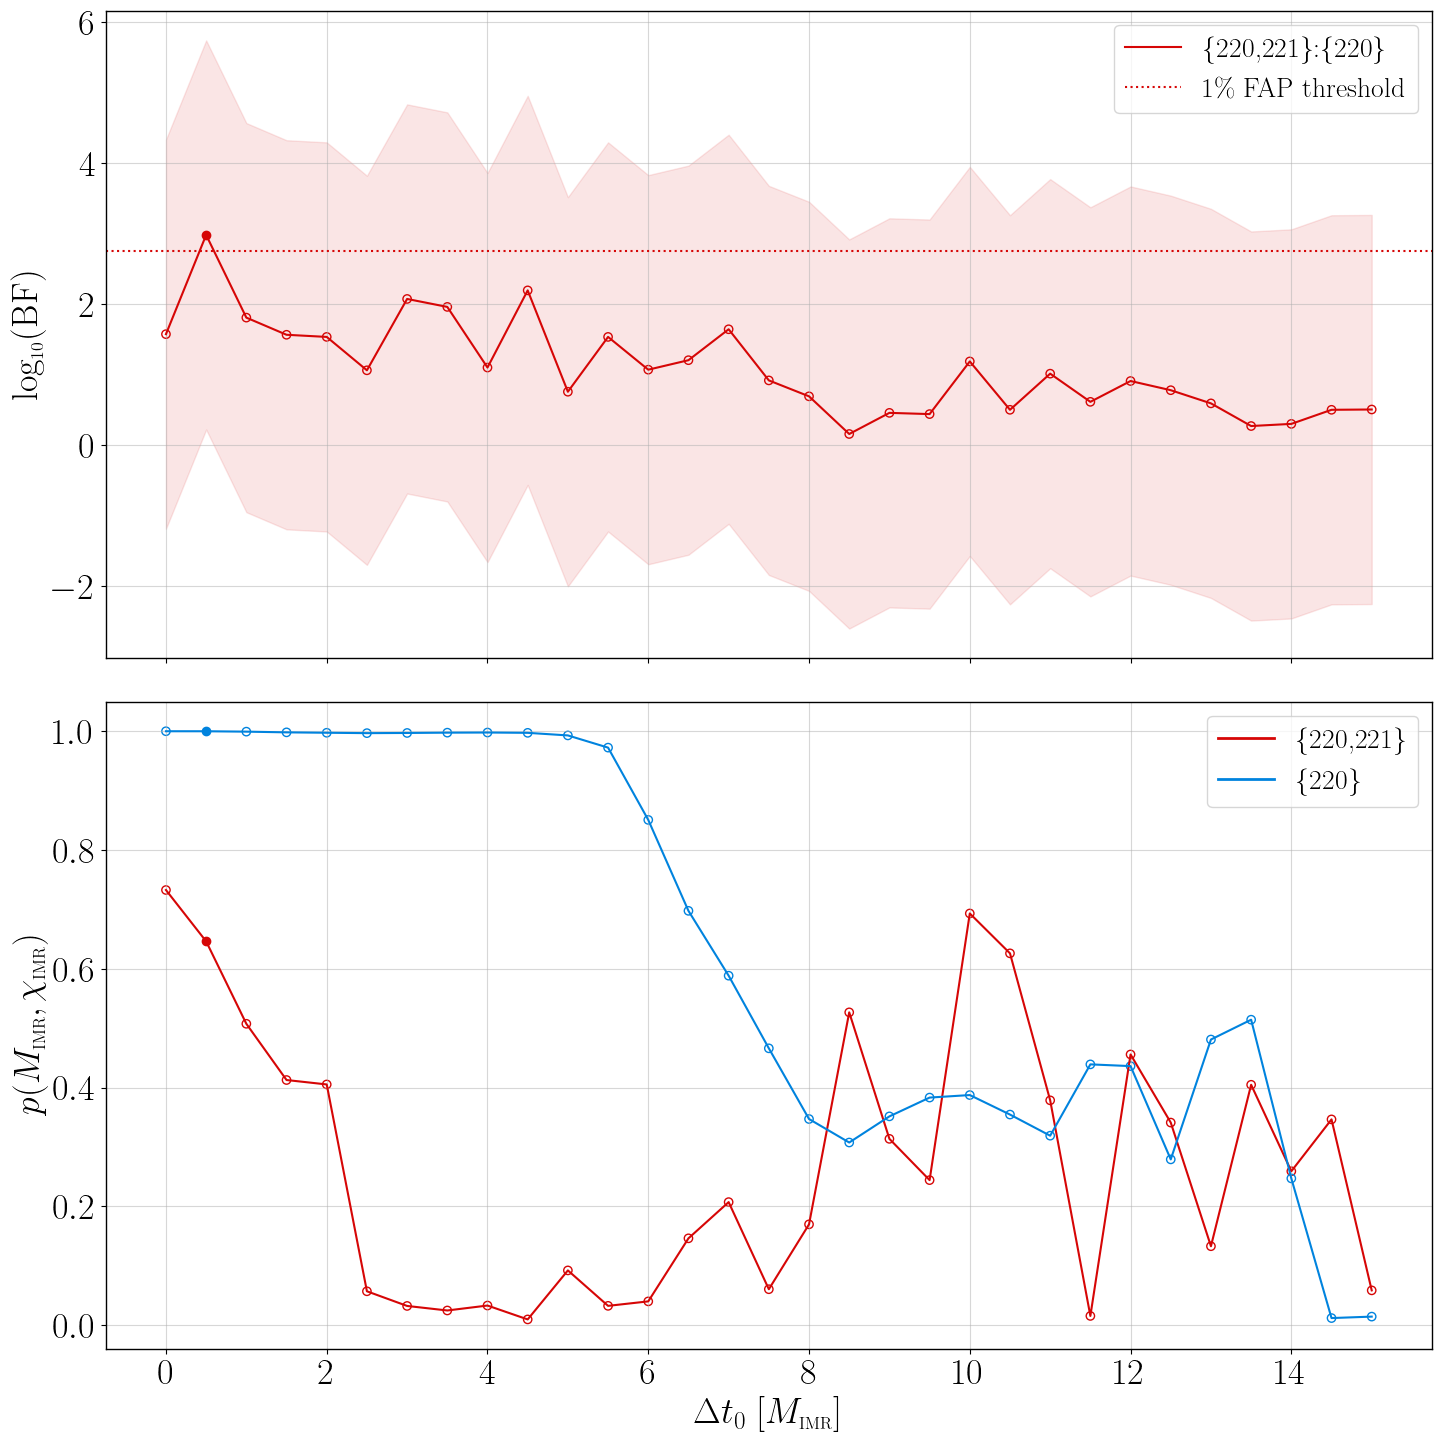

In [11]:
agnostic = 9.599196287249947/np.log(10)
conditional = 6.353797567210358/np.log(10)

fig, axs = pl.subplots(2, sharex = True)
time_arr, ref_mode, filt_mode = np.loadtxt("results/GW150914_evidences.txt")
BF = (filt_mode - ref_mode)/np.log(10)
significant = BF > conditional

axs[0].plot(time_arr, BF, label="\{220,221\}:\{220\}", color=color_arr[0])
axs[0].scatter(time_arr[significant], BF[significant], color=color_arr[0], marker='o')
axs[0].scatter(time_arr[np.logical_not(significant)], BF[np.logical_not(significant)], 
               marker='o', facecolors='none', color=color_arr[0])
axs[0].fill_between(time_arr, BF+conditional, BF-conditional, color=color_arr[0], alpha=0.1)
axs[0].axhline(conditional, ls=':', color=color_arr[0], label='1\% FAP threshold')
axs[0].set_ylabel(r"log$_{\scriptscriptstyle 10}$(BF)")
axs[0].legend(loc='upper right', fontsize=20)
pl.tight_layout()

filename = "results/GW150914_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

plotting_labels=["\{220,221\}","\{220\}"]
time_arr = data[-1]
pvalues = data[:-1]
mode_list = mode_list[::-1]
pvalues = pvalues[::-1]
for idx, val in enumerate(pvalues):
    axs[1].plot(time_arr, val, label=plotting_labels[idx], color=color_arr[idx])
    axs[1].scatter(time_arr[significant], val[significant], color=color_arr[idx], marker='o')
    axs[1].scatter(time_arr[np.logical_not(significant)], val[np.logical_not(significant)], 
                   marker='o', facecolors='none', color=color_arr[idx])
leg = axs[1].legend(loc='upper right', fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ [$M_\textrm{\large IMR}$]')
axs[1].set_ylabel(r"$p(M_\textrm{\large IMR},\chi_\textrm{\large IMR})$")

pl.tight_layout()
pl.savefig("plots/GW150914.pdf")
pl.savefig("plots/GW150914.png")
pl.show()

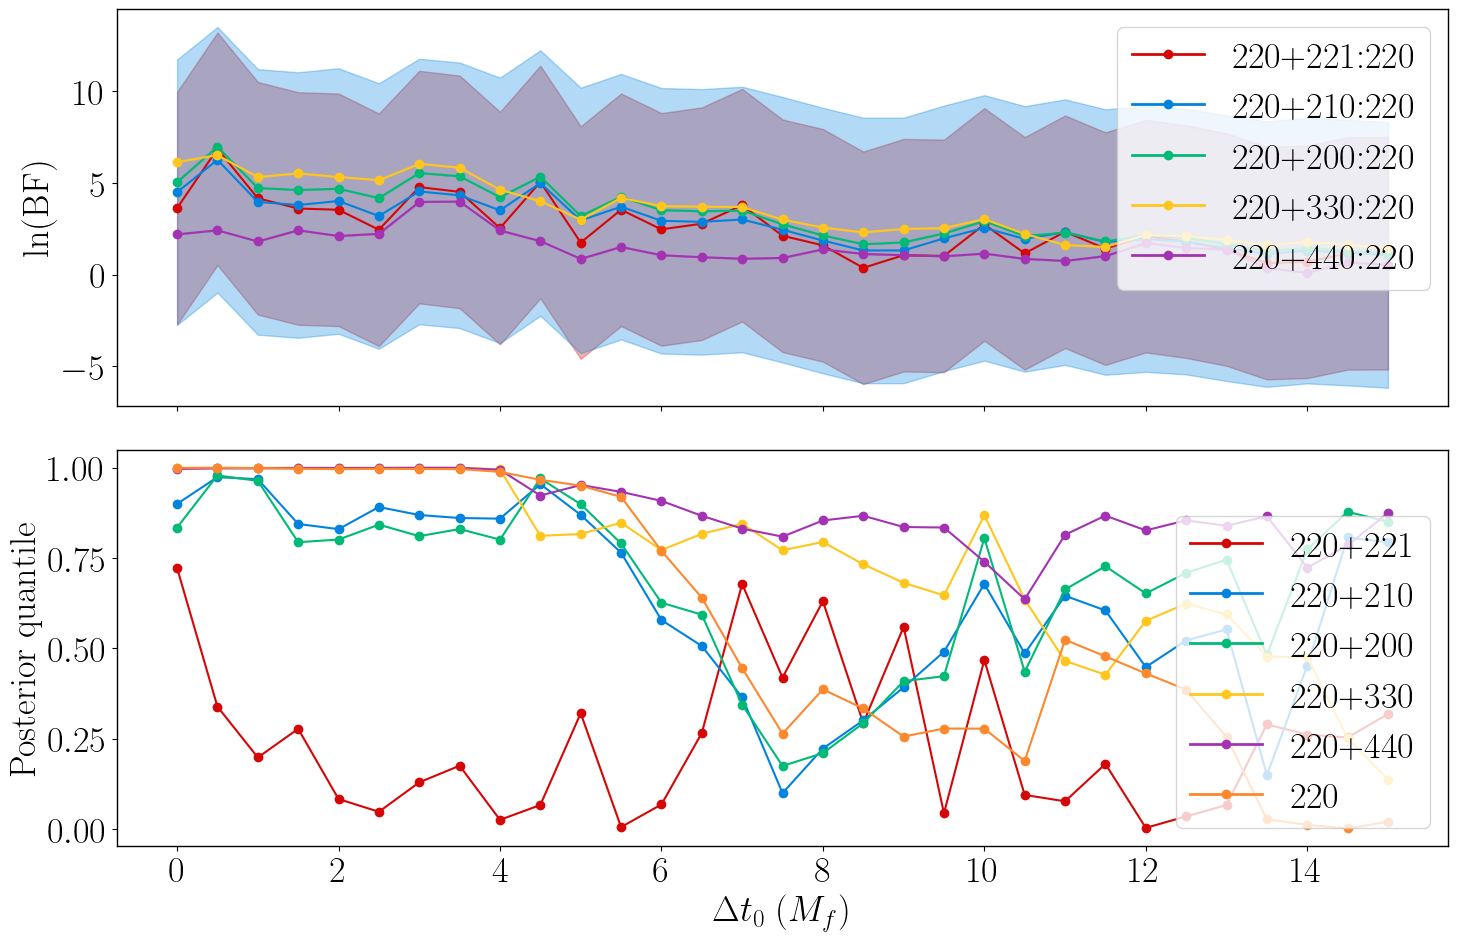

In [6]:
fig, axs = pl.subplots(2, figsize = [15, 10], sharex = True)
filename = "results/GW150914_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
BF_curves = data[:-1]
for idx, val in enumerate(BF_curves):
    axs[0].plot(time_arr, val, marker='o', label=mode_list[idx]+':220', color=color_arr[idx])
    error_bar = thresh_dict.get(mode_list[idx]+':220', 0)
    axs[0].fill_between(time_arr, val-error_bar, val+error_bar,
                   alpha=0.3, color=color_arr[idx])
leg = axs[0].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel("ln(BF)")

filename = "results/GW150914_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

temp = {}
for idx, mode in enumerate(mode_list):
    temp[mode] = data[idx]
plotting = ["220+221", "220+210", "220+200", "220+330", "220+440", "220"]

time_arr = data[-1]
pvalues = data[:-1]
for idx, mode in enumerate(plotting):
    axs[1].plot(time_arr, temp[mode], marker='o', label=mode, color=color_arr[idx])
leg = axs[1].legend(loc = 'lower right')
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ ($M_f$)')
axs[1].set_ylabel("Posterior quantile")

pl.tight_layout()
pl.savefig("plots/GW150914_2mode_results.pdf")

In [ ]:
fig, axs = pl.subplots(2, figsize = [15, 10], sharex = True)
filename = "results/0305_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
BF_curves = data[:-1]
for idx, val in enumerate(BF_curves):
    axs[0].plot(time_arr, val, marker='o', label=mode_list[idx]+':220', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh_dict[mode_list[idx]+':220'], val+thresh_dict[mode_list[idx]+':220'],
                   alpha=0.3, color=color_arr[idx])
leg = axs[0].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel("ln(BF)")

filename = "results/0305_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues[:-1]):
    axs[1].plot(time_arr, val, marker='o', label=mode_list[idx], color=color_arr[idx])
leg = axs[1].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel("Time (M)")
axs[1].set_ylabel("p value")

pl.tight_layout()
pl.savefig("plots/0305_2mode_results.pdf")

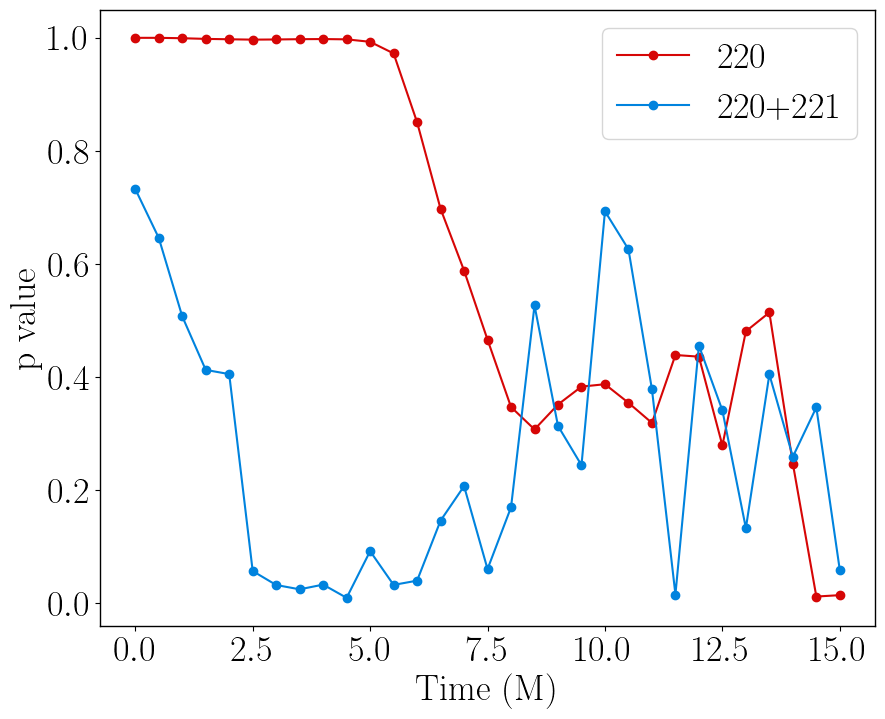

In [11]:
filename = "results/GW150914_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]

for idx, val in enumerate(pvalues):
    pl.plot(time_arr, val, marker='o', label=mode_list[idx], color=color_arr[idx])
pl.legend()
pl.xlabel("Time (M)")
pl.ylabel("p value")
pl.savefig("plots/SXS:0305_2mode_pvalue.pdf")

In [5]:
time_arr, nofilter_arr = np.loadtxt("results/data/nofilter/nofilter.dat")

FileNotFoundError: results/data/nofilter/nofilter.dat not found.

<Figure size 3000x1800 with 0 Axes>

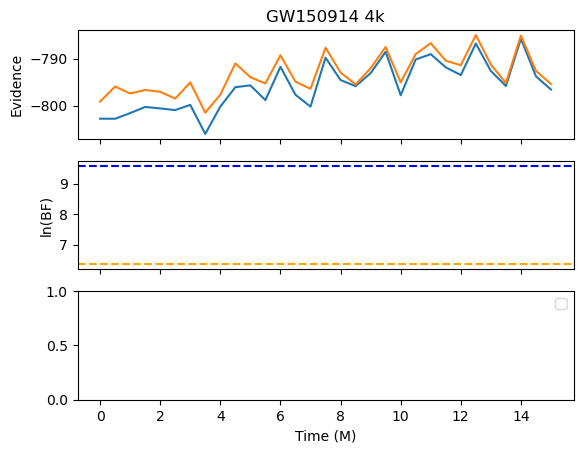

In [11]:
pl.figure(figsize=(10,6), dpi=300)
fig, axs = pl.subplots(3, sharex = True)

axs[0].plot(time_arr, mode_evidences[ref_mode], label=ref_mode)
axs[0].plot(time_arr, mode_evidences[mode_list[0]], label=mode_list[0])
axs[0].set_ylabel("Evidence")
pl.legend()

axs[1].set_ylabel("ln(BF)")
# pl.title("GW150914 evidence curve")
axs[1].axhline(9.599196287249947, c='blue', ls='--', label='Agnostic 1% FAP')
axs[1].axhline(6.353797567210358, c='orange', ls='--', label='Posterior 1% FAP')

axs[0].set_title("GW150914 4k")

axs[2].set_xlabel("Time (M)")
# pl.savefig("GW150914.pdf")
pl.show()

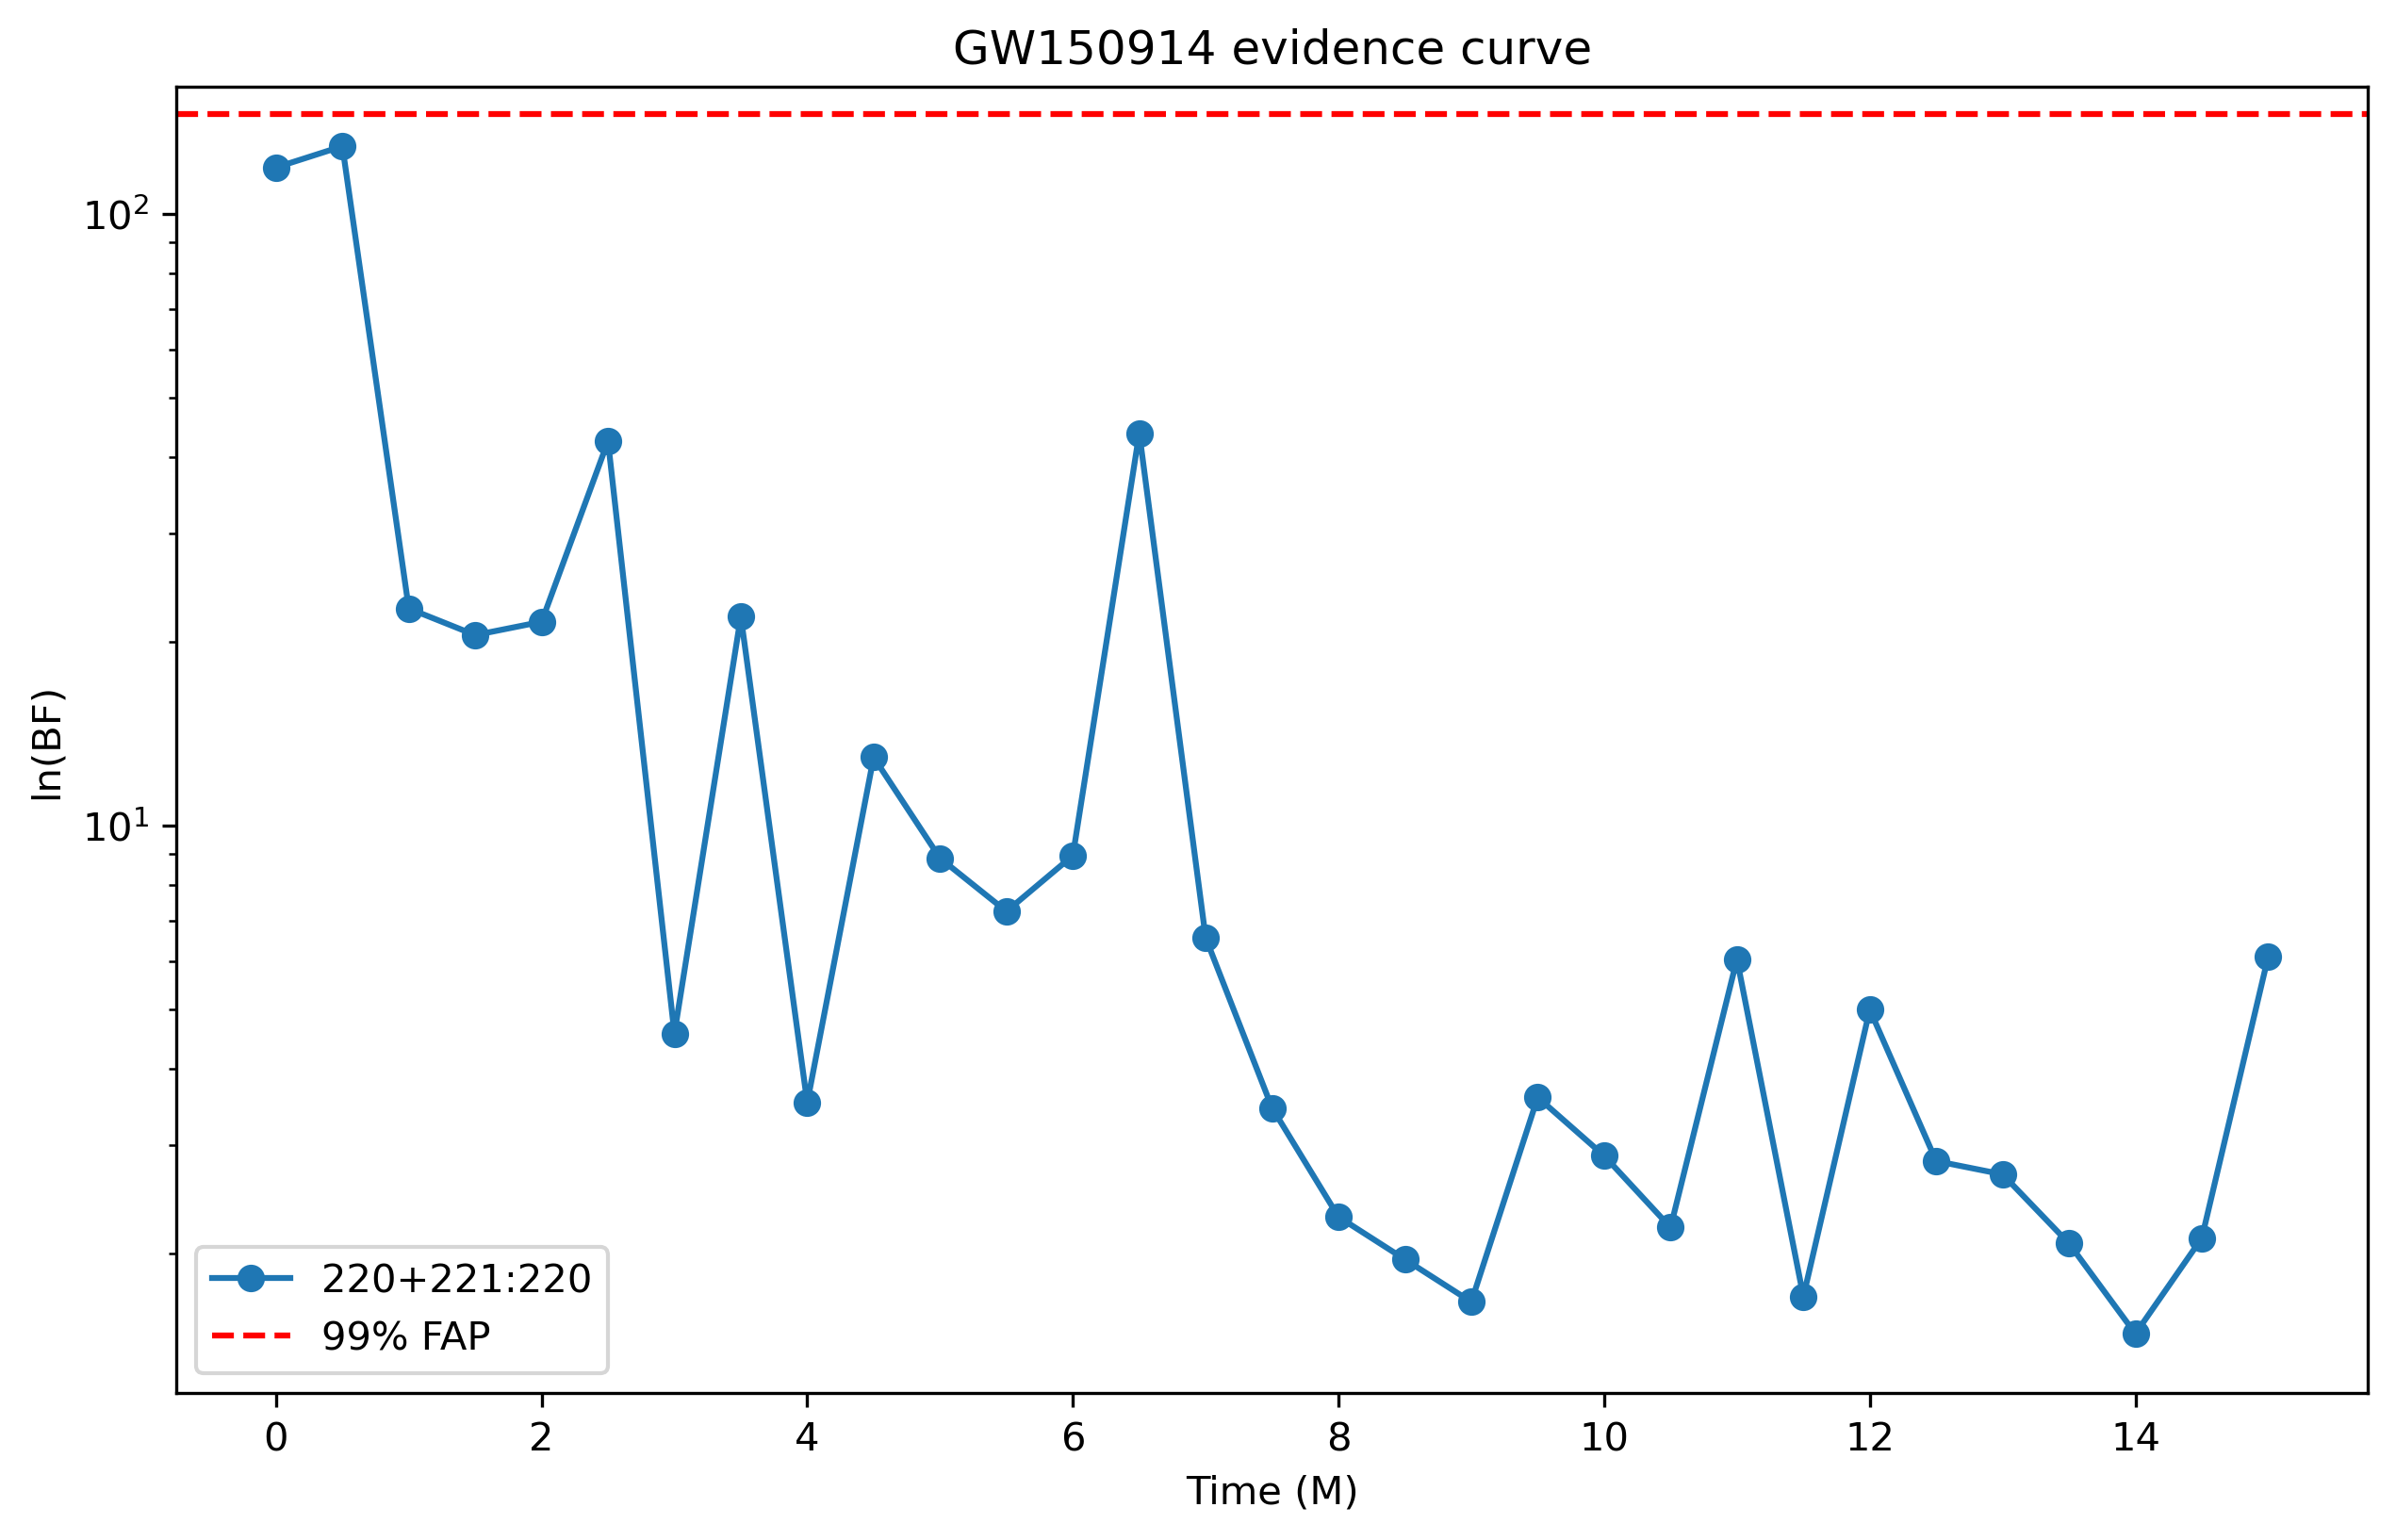

In [7]:
mode_list = ["220+221"]
ref_mode = "220"
color_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']
time_arr = []
ref_evidence = []
evidence_arr = []
pl.figure(figsize=(10,6), dpi=300)

files = natsorted(glob.glob(directory+ref_mode+"/GW150914_noiseDuration=16_srate=8192_t=*"))
for idx, name in enumerate(files):
    [likelihood_data, evidence, time_offset, filter_str, credible, \
     chi_lower, chi_upper, mass_lower, mass_upper, \
     massspace, chispace, mass_grid, chi_grid, \
     projected_mass, projected_chi] = load_data(ref_mode+'/'+files[idx].split('/')[-1])
    
    time_arr.append(time_offset)
    ref_evidence.append(evidence)

for idx0, mode in enumerate(mode_list):
    files = natsorted(glob.glob(directory+mode+"/GW150914_noiseDuration=16_srate=8192_t=*"))
    evidence_arr = []
    for idx1, name in enumerate(files):
        [likelihood_data, evidence, time_offset, filter_str, credible, \
         chi_lower, chi_upper, mass_lower, mass_upper, \
         massspace, chispace, mass_grid, chi_grid, \
         projected_mass, projected_chi] = load_data(mode+'/'+files[idx1].split('/')[-1])

        evidence_arr.append(evidence)
    BF = np.subtract(evidence_arr, ref_evidence)
    pl.semilogy(time_arr, np.exp(BF), label=mode+":220",
           c = color_arr[idx0], marker='o')

pl.xlabel("Time (M)")
pl.ylabel("ln(BF)")
pl.title("GW150914 evidence curve")
pl.axhline(np.exp(4.98), c='r', ls='--', label='99% FAP')
pl.legend()
pl.savefig("GW150914.pdf")
pl.show()